# **D209 Performance Assessment 1:** Classification  

**Student:** Chris Fischer  
**ID:** 011933891  
**Dataset:** Churn  
---

### *Research Question*  

Which customers likely to be most technically minded (self identify as "techie")?

## Initialization
---

In [17]:
#import needed libraries
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

#allow pd.describe to show all columns of the data frame [In-Text Citation: (Ray, 2020)]
pd.options.display.max_columns = None 

#Initialize some lists to speed cleansing
survey_answers = [1,2,3,4,5,6,7,8]
numerical_variables = ['Age','Income','Children','Population']
categorical_variables = ['State','Area']
onehot_variables = ['Marital','Gender',]
yes_no_variables = ['Techie','Port_modem','Tablet','Phone','Multiple','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

# Explanatory variables
X_full = numerical_variables + categorical_variables + onehot_variables + yes_no_variables
X_vars = X_full.copy()
X_vars.remove('Techie')

#  Dependent variable
y_vars = ['Techie']

#load church_missing_data.csv
df = pd.read_csv('churn_clean.csv', keep_default_na=False)
df[X_full].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               10000 non-null  int64  
 1   Income            10000 non-null  float64
 2   Children          10000 non-null  int64  
 3   Population        10000 non-null  int64  
 4   State             10000 non-null  object 
 5   Area              10000 non-null  object 
 6   Marital           10000 non-null  object 
 7   Gender            10000 non-null  object 
 8   Techie            10000 non-null  object 
 9   Port_modem        10000 non-null  object 
 10  Tablet            10000 non-null  object 
 11  Phone             10000 non-null  object 
 12  Multiple          10000 non-null  object 
 13  OnlineSecurity    10000 non-null  object 
 14  OnlineBackup      10000 non-null  object 
 15  DeviceProtection  10000 non-null  object 
 16  TechSupport       10000 non-null  object 

## Cleaning
---

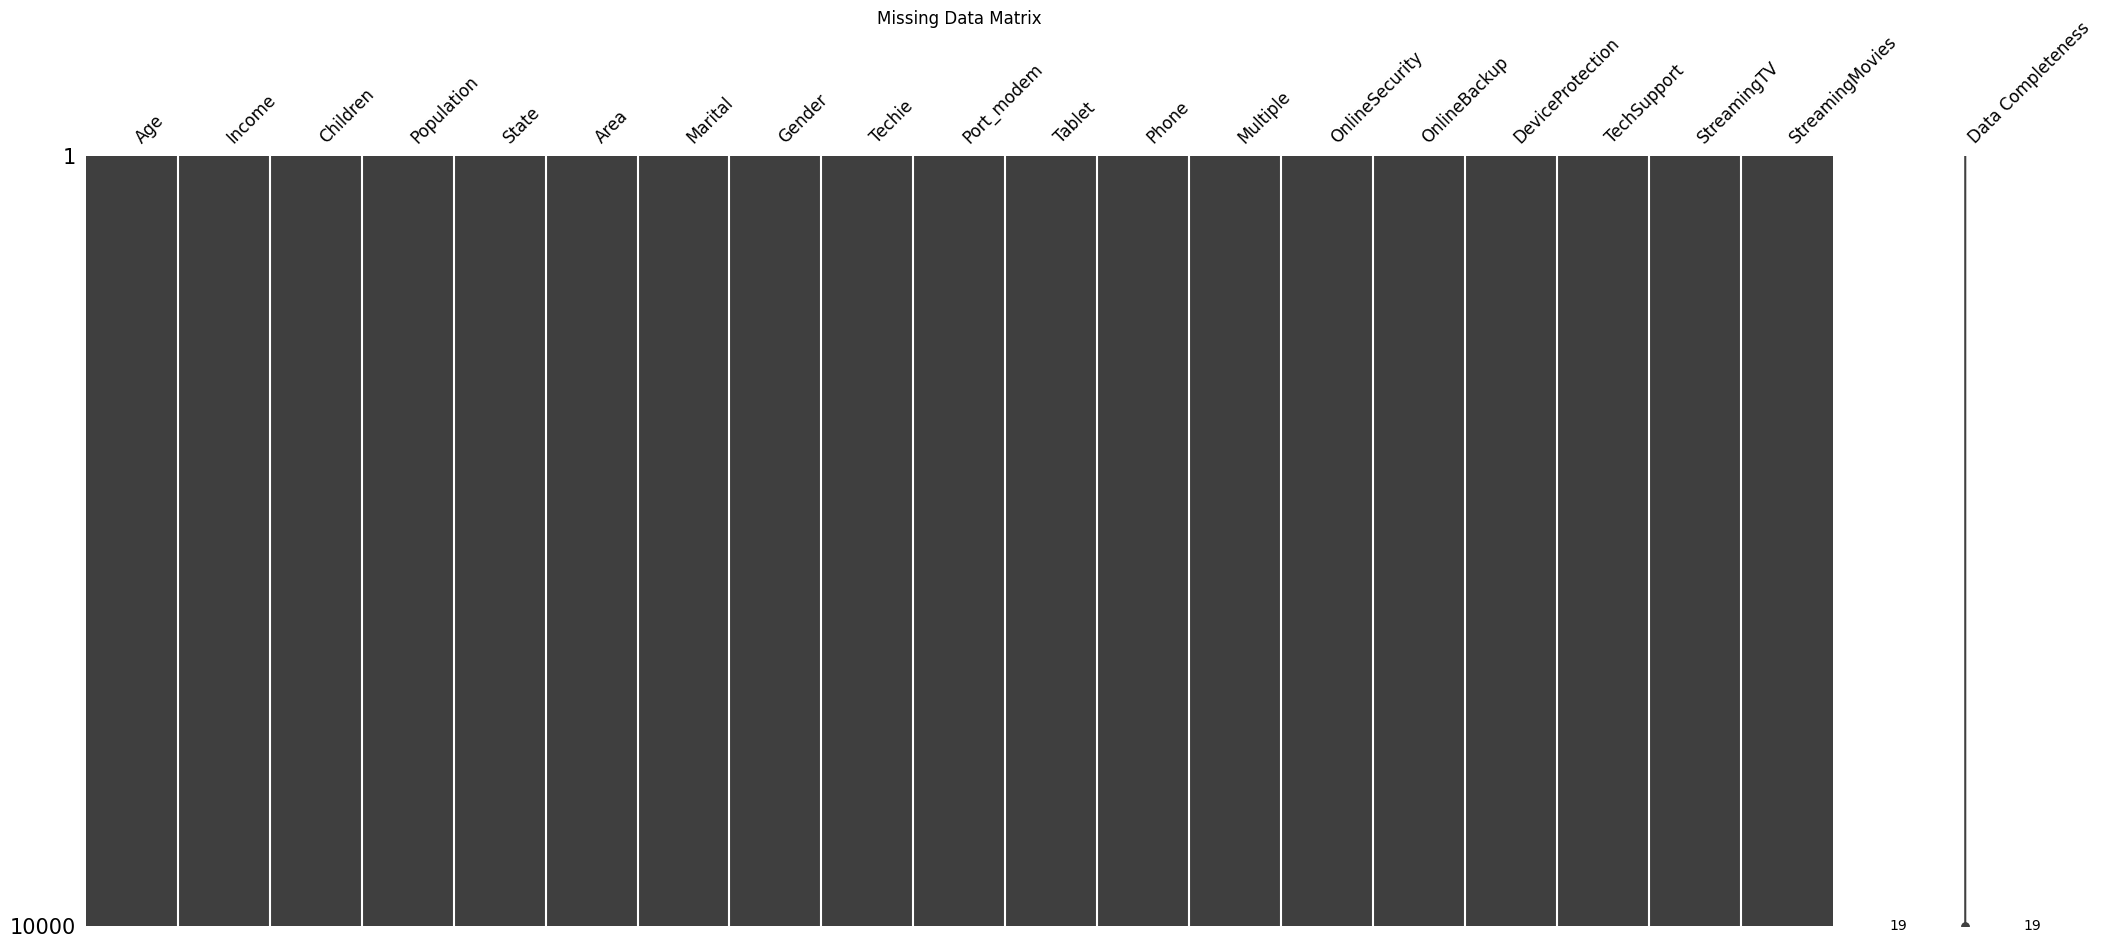

In [18]:
# Check missing data
msno.matrix(df[X_full], fontsize = 12, labels=True)
plt.title('Missing Data Matrix')
plt.show()

In [19]:
#Check values in yes/no variables
print(df[yes_no_variables][~df[yes_no_variables].isin(['Yes','No'])].count())

Techie              0
Port_modem          0
Tablet              0
Phone               0
Multiple            0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


In [20]:
#Detect potential outliers
df_z = (df[numerical_variables] - df[numerical_variables].mean())/df[numerical_variables].std(ddof=0)
outlier_cols = df_z.loc[: , (df_z > 3.0).any()].columns
for col in outlier_cols :
    cnt = len(df_z[df_z[col]>3])
    minval, maxval = df[col].min(), df[col].max()
    print('Likely outlier for {0:<20}\t Count: {1:7d} ({2:5.2%} of observations)\tMin: {3:>9.2f}\tMax: {4:>9.2f}'.format(col,cnt,cnt/10000,minval,maxval))

Likely outlier for Income              	 Count:     145 (1.45% of observations)	Min:    348.67	Max: 258900.70
Likely outlier for Children            	 Count:     191 (1.91% of observations)	Min:      0.00	Max:     10.00
Likely outlier for Population          	 Count:     219 (2.19% of observations)	Min:      0.00	Max: 111850.00


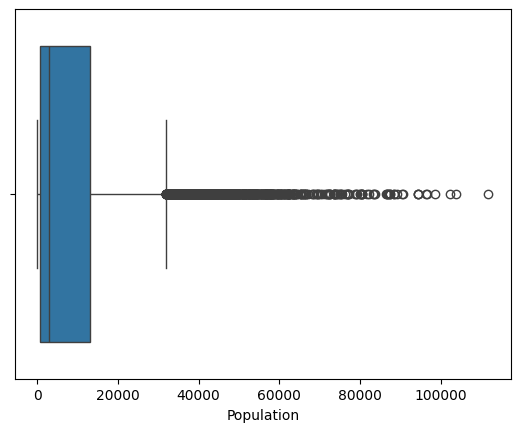

Population
0        97
94       14
39       12
110      12
227      11
         ..
9295      1
24092     1
10211     1
26177     1
12230     1
Name: count, Length: 5933, dtype: int64


In [21]:
# Deeper look at Population
sns.boxplot(data=df, x='Population')
plt.show()
print(df['Population'].value_counts())

## Transformation
---

In [22]:
# Drop rows with Population <= 0
df = df[df.Population > 0]
print(df['Population'].count())

9903


In [23]:
# Change "Never Married" to "NeverMarried" to prevent one-hot encoding problems later
df['Marital'] = df['Marital'].replace('\s+', '',regex=True)
print(df['Marital'].value_counts())

Marital
Divorced        2067
Widowed         2013
Separated       1990
NeverMarried    1935
Married         1898
Name: count, dtype: int64


In [24]:
# Reexpress yes/no columns as numbers [In-Text Citation: (Eiler, 2017)]
yesno_dict = {'No': 0, 'Yes': 1}
for col in yes_no_variables:
    df[col] = df[col].map(yesno_dict)
print(df[yes_no_variables].info())

# Rexpress State with frequency encoding [In-Text Citation: (Neural Ninja, 2023)]
df['State'] = df['State'].map(df['State'].value_counts().to_dict())
print(df['State'].info())

# Rexpress Area with simple ordinal encoding
area_map = {'Rural': 1, 'Suburban': 2, 'Urban' : 3}
df['Area'] = df['Area'].map(area_map)
print(df['Area'].info())

<class 'pandas.core.frame.DataFrame'>
Index: 9903 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Techie            9903 non-null   int64
 1   Port_modem        9903 non-null   int64
 2   Tablet            9903 non-null   int64
 3   Phone             9903 non-null   int64
 4   Multiple          9903 non-null   int64
 5   OnlineSecurity    9903 non-null   int64
 6   OnlineBackup      9903 non-null   int64
 7   DeviceProtection  9903 non-null   int64
 8   TechSupport       9903 non-null   int64
 9   StreamingTV       9903 non-null   int64
 10  StreamingMovies   9903 non-null   int64
dtypes: int64(11)
memory usage: 928.4 KB
None
<class 'pandas.core.series.Series'>
Index: 9903 entries, 0 to 9999
Series name: State
Non-Null Count  Dtype
--------------  -----
9903 non-null   int64
dtypes: int64(1)
memory usage: 154.7 KB
None
<class 'pandas.core.series.Series'>
Index: 9903 entries, 0 to 9999
Ser

In [25]:
# Scaling and One-hot encoding
# [In-Text Citation: (Piepenbreier, 2022)]
# [In-Text Citation: (Buser, 2023)]
preprocessor = make_column_transformer(
 (StandardScaler(), numerical_variables),
 (OneHotEncoder(), onehot_variables),
  remainder='passthrough',
  verbose_feature_names_out=False
)

X = pd.DataFrame(preprocessor.fit_transform(df[X_vars]), columns=preprocessor.get_feature_names_out())
y = df[y_vars]

In [26]:
# Extract prepared data set to CSV
df_full = pd.concat([X, y], axis=1)
df_full.to_csv('churn_prepared.csv', index=False)

## Modeling
---

In [27]:
# Split data into train and test sets with 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5470, stratify=y)
X_train.to_csv('churn_X_train.csv', index=False)
X_test.to_csv('churn_X_test.csv', index=False)
y_train.to_csv('churn_y_train.csv', index=False)
y_test.to_csv('churn_y_test.csv', index=False)

In [28]:
# Set-up hyperparameter values
neighbors = list(range(1, 31))
parameters = dict(n_neighbors = neighbors)

# Set-up base model
knn = KNeighborsClassifier()

# Set-up cross validation
clf = GridSearchCV(knn, parameters, cv=5, scoring='f1', verbose=1, return_train_score=False, n_jobs=-1)

# Fit the model
clf.fit(X_train,y_train.values.ravel()) # [In-Text Citation (MacPhee-Cobb, 2016)]
clf_best = clf.best_estimator_

# Print results
print('Best score : ' , clf.best_score_)
print('Best params : ' , clf.best_params_)
print(clf_best.get_params())


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best score :  0.14306419595615444
Best params :  {'n_neighbors': 1}
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}


## Model Evaluation
---

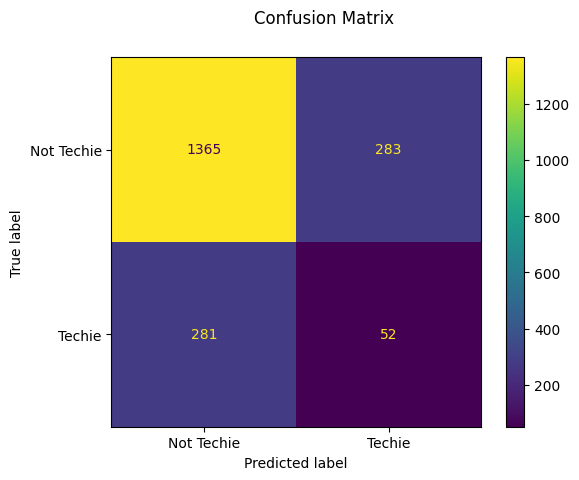

In [29]:
# Plot the confusion matrices
y_pred_test = clf_best.predict(X_test)
cm_test = confusion_matrix(
    y_test, y_pred_test)
cmd_test = ConfusionMatrixDisplay(cm_test, display_labels=['Not Techie','Techie'])

cmd_test.plot()
plt.suptitle("Confusion Matrix")
plt.show()

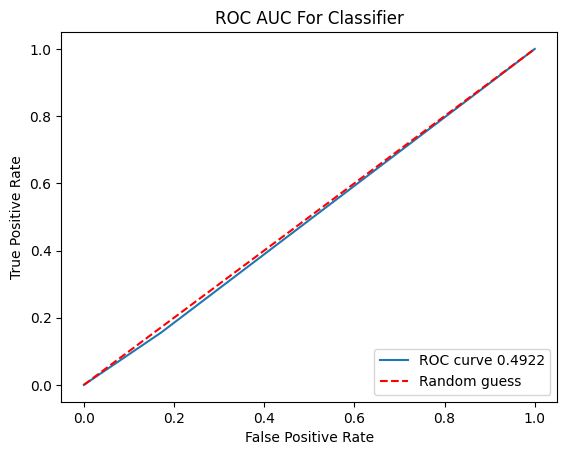

In [30]:
# Calculate ROC AUC
y_pred_proba = clf_best.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr,tpr,label=f'ROC curve {auc:.4f}')
plt.plot([0, 1], [0, 1], '--', color='red', label='Random guess')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC AUC For Classifier')
plt.show()

In [31]:
# Display additional metrics
print(f'Accuracy  : {accuracy_score(y_test,y_pred_test):.5f}')
print(f'Precision : {precision_score(y_test,y_pred_test):.5f}')
print(f'Recall    : {recall_score(y_test,y_pred_test):.5f}')
print(f'F1        : {f1_score(y_test,y_pred_test):.5f}')

Accuracy  : 0.71530
Precision : 0.15522
Recall    : 0.15616
F1        : 0.15569
